In [157]:
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections.abc import Iterable

_ROOT_DIR = os.path.join('.', 'samples', 'axis-check')
_EEG_RAW_COLNAMES =     { 'RAW_TP9':'TP9', 
                          'RAW_TP10':'TP10', 
                          'RAW_AF7':'AF7', 
                          'RAW_AF8':'AF8', 
                          'Accelerometer_X':'accel_x', 
                          'Accelerometer_Y':'accel_y', 
                          'Accelerometer_Z':'accel_z', 
                          'Gyro_X':'gyro_x', 
                          'Gyro_Y':'gyro_y',
                          'Gyro_Z':'gyro_z'     }
_EEG_MUSE_COLNAMES =    [ 'Delta_TP9','Delta_TP10','Delta_AF7','Delta_AF8',
                          'Theta_TP9', 'Theta_TP10', 'Theta_AF7', 'Theta_AF8', 
                          'Alpha_TP9', 'Alpha_TP10', 'Alpha_AF7', 'Alpha_AF8',
                          'Beta_TP9', 'Beta_TP10', 'Beta_AF7', 'Beta_AF8',
                          'Gamma_TP9', 'Gamma_TP10', 'Gamma_AF7', 'Gamma_AF8'     ]
_COLOR_MAP =            { 'accel_x': 'red',
                          'accel_y': 'orange',
                          'accel_z': 'blue',
                          'gyro_x': 'red',
                          'gyro_y': 'orange',
                          'gyro_z': 'blue',
                          'x': 'red',
                          'y': 'orange',
                          'z': 'blue'  }

In [158]:
class Experiment:
    def __init__(self, root_dir:str, muse_imu_filename:str, vr_imu_filename:str, start_buffer:int=1000, end_buffer:int=1000):
        self.root_dir = root_dir
        muse, _, _ = self.read_eeg(os.path.join(self.root_dir, muse_imu_filename))
        vr = pd.read_csv(os.path.join(self.root_dir, vr_imu_filename))
        
        # Filter based on min and max timestamps
        raw_min_unix = max(muse['unix_ms'].min(), vr['unix_ms'].min())
        raw_max_unix = min(muse['unix_ms'].max(), vr['unix_ms'].max())
        self.min_unix = raw_min_unix + start_buffer
        self.max_unix = raw_max_unix - end_buffer
        print("Minimum UNIX timestamp:", self.min_unix)
        print("Maximum UNIX timestamp:", self.max_unix)

        # Set
        self.muse = muse[muse['unix_ms'].between(self.min_unix, self.max_unix)]
        self.muse['rel_unix_ms'] = self.muse['unix_ms'] - self.min_unix
        self.vr = vr[vr['unix_ms'].between(self.min_unix, self.max_unix)]
        self.vr['rel_unix_ms'] = self.vr['unix_ms'] - self.min_unix
    
    def plot_raw(self, outname=None, show:bool=True):
        fig, axes = plt.subplots(2,6,figsize=(30,5),sharex=True)

        # Filter based on min and max timestamps, also considering start and end buffers
        muse = self.muse
        vr = self.vr

        # Plot VR data
        vr_x = vr['rel_unix_ms'].to_list()
        self.subplot(axes[0][0], vr_x, vr['accel_z'].to_list(), _COLOR_MAP['z'], 'VR IMU: Accelerometer Z')
        self.subplot(axes[0][1], vr_x, vr['accel_x'].to_list(), _COLOR_MAP['x'], 'VR IMU: Accelerometer X')
        self.subplot(axes[0][2], vr_x, vr['accel_y'].to_list(), _COLOR_MAP['y'], 'VR IMU: Accelerometer Y')
        self.subplot(axes[0][3], vr_x, vr['gyro_x'].to_list(), _COLOR_MAP['x'], 'VR IMU: Gyroscope X')
        self.subplot(axes[0][4], vr_x, vr['gyro_z'].to_list(), _COLOR_MAP['z'], 'VR IMU: Gyroscope Z')
        self.subplot(axes[0][5], vr_x, vr['gyro_y'].to_list(), _COLOR_MAP['y'], 'VR IMU: Gyroscope Y')
        
        # Plot muse data
        muse_x = muse['rel_unix_ms'].to_list()
        self.subplot(axes[1][0], muse_x, muse['accel_x'].to_list(), _COLOR_MAP['x'], 'Muse IMU: Accelerometer X')
        self.subplot(axes[1][1], muse_x, muse['accel_y'].to_list(), _COLOR_MAP['y'], 'Muse IMU: Accelerometer Y')
        self.subplot(axes[1][2], muse_x, muse['accel_z'].to_list(), _COLOR_MAP['z'], 'Muse IMU: Accelerometer Z')
        self.subplot(axes[1][3], muse_x, muse['gyro_y'].to_list(), _COLOR_MAP['y'], 'Muse IMU: Gyroscope Y')
        self.subplot(axes[1][4], muse_x, muse['gyro_x'].to_list(), _COLOR_MAP['x'], 'Muse IMU: Gyroscope X')
        self.subplot(axes[1][5], muse_x, muse['gyro_z'].to_list(), _COLOR_MAP['z'], 'Muse IMU: Gyroscope Z')

        # Show
        fig.text(0.5, 0, 'Relative UNIX Milliseconds (ms)', ha='center', fontweight='bold')
        fig.text(0, 0.5, 'Output Value', va='center', rotation='vertical', fontweight='bold')
        fig.text(0.5, 1.0, 'IMU Output Values per Axis', ha='center', fontweight='bold', fontsize=15)
        plt.legend()
        plt.tight_layout()
        if outname is not None: 
            if isinstance(outname, str):
                plt.savefig(os.path.join(self.root_dir, outname), bbox_inches='tight', dpi=300)
            elif isinstance(outname, Iterable):
                for o in outname: plt.savefig(os.path.join(self.root_dir, o), bbox_inches='tight', dpi=300)
            else:
                print("WARNING: supplied outname invalid type. Expects either str or Iterable[str]")
        if show:    plt.show()
        else:       plt.close()

    def plot_individual(self, vr_colname:str, muse_colname:str, unix_bounds:(int,int), title:str, figsize=(12.5,7.5), outname=None, show:bool=True):
        fig, axes = plt.subplots(2,1,figsize=figsize, sharex=True)
        muse = self.muse[self.muse['rel_unix_ms'].between(unix_bounds[0],unix_bounds[1])]
        vr = self.vr[self.vr['rel_unix_ms'].between(unix_bounds[0],unix_bounds[1])]

        self.subplot(axes[0], vr['rel_unix_ms'].to_list(), vr[vr_colname].to_list(), _COLOR_MAP[vr_colname], f'VR IMU: {vr_colname}')
        self.subplot(axes[1], muse['rel_unix_ms'].to_list(), muse[muse_colname].to_list(), _COLOR_MAP[muse_colname], f'Muse IMU: {muse_colname}')
        
        ylabel = 'Acceleration (m/s^2)' if vr_colname.startswith('accel') else 'Gyroscope (Rad/sec)'
        fig.text(0.5, 0, 'Relative UNIX Milliseconds (ms)', ha='center', fontweight='bold')
        fig.text(0, 0.5, ylabel, va='center', rotation='vertical', fontweight='bold')
        fig.text(0.5, 1.0, title, ha='center', fontweight='bold', fontsize=15)
        plt.tight_layout()
        if outname is not None: 
            if isinstance(outname, str): plt.savefig(os.path.join(self.root_dir, outname), bbox_inches='tight', dpi=300)
            elif isinstance(outname, Iterable): 
                for o in outname: plt.savefig(os.path.join(self.root_dir, o), bbox_inches='tight', dpi=300)
            else: print("WARNING: supplied outname invalid type. Expects either str or Iterable[str]")
        if show:    plt.show()
        else:       plt.close()



    @staticmethod
    def timestamp_to_unix_seconds(x):
        date_format = datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
        unix_seconds = datetime.datetime.timestamp(date_format)
        return unix_seconds
    @staticmethod
    def timestamp_to_unix_milliseconds(x):
        date_format = datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
        unix_seconds = datetime.datetime.timestamp(date_format)
        unix_milliseconds = int(unix_seconds * 1000)
        return unix_milliseconds
    @classmethod
    def read_eeg(cls, filepath:str):
        # Assertion to check file existence
        assert os.path.exists(filepath), f'EEG file {filepath} does not exist...'
        # Initial read
        df = pd.read_csv(filepath)
        # Generate timestamp features
        df['unix_ms'] = df['TimeStamp'].apply(cls.timestamp_to_unix_milliseconds)
        df['unix_sec'] = df['TimeStamp'].apply(cls.timestamp_to_unix_seconds)    
        df['rel_sec'] = df['unix_sec'] - df['unix_sec'].iloc[0]
        df['rel_ms'] = df['unix_ms'] - df['unix_ms'].iloc[0] 
        # separate blinks from raw data
        signals = df[df['Elements'].isna()]
        blinks = df[df['Elements']=='/muse/elements/blink']
        blinks = blinks[['TimeStamp', 'unix_sec', 'unix_ms', 'rel_sec', 'rel_ms']]    
        # Get raw data, then rename the features
        raw_df = signals[['unix_sec','unix_ms', 'rel_sec', 'rel_ms', *list(_EEG_RAW_COLNAMES.keys())]]
        raw_df.rename(columns=_EEG_RAW_COLNAMES, inplace=True)
        # Get processed data
        processed_df = signals[['unix_sec','unix_ms', 'rel_sec', 'rel_ms', *_EEG_MUSE_COLNAMES]]
        # return 
        return raw_df, processed_df, blinks
    @staticmethod
    def subplot(ax, x, y, color, title):
        ax.plot(x, y, color=color)
        ax.set_title(title)

experiment = Experiment(_ROOT_DIR, 'muse_imu.csv', 'vr_imu.csv')

Minimum UNIX timestamp: 1766350229234
Maximum UNIX timestamp: 1766350251846


/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_36635/909743451.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df.rename(columns=_EEG_RAW_COLNAMES, inplace=True)
/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_36635/909743451.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.muse['rel_unix_ms'] = self.muse['unix_ms'] - self.min_unix
/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_36635/909743451.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_36635/909743451.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


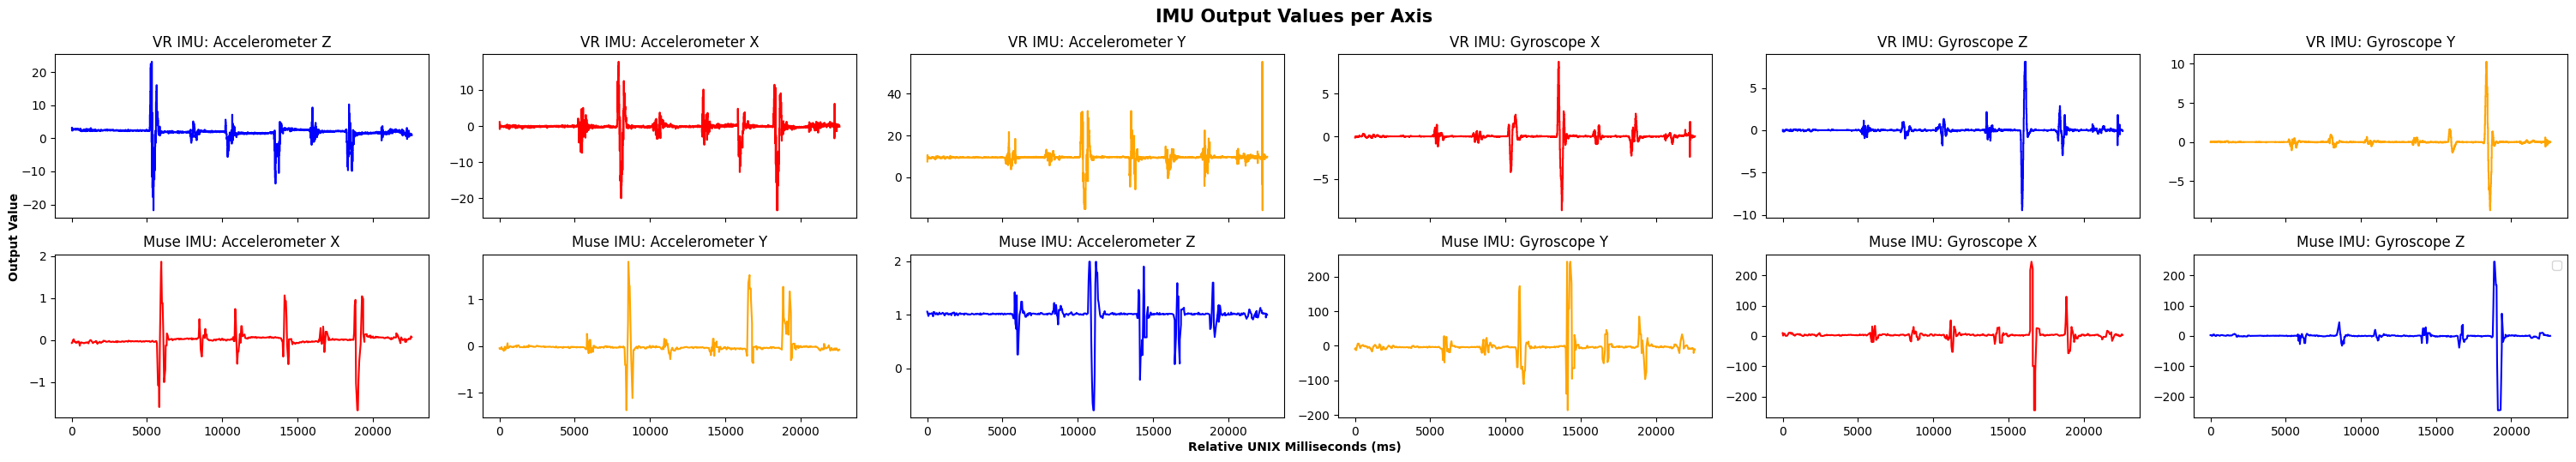

In [159]:
experiment.plot_raw(outname='raw_imu.png')

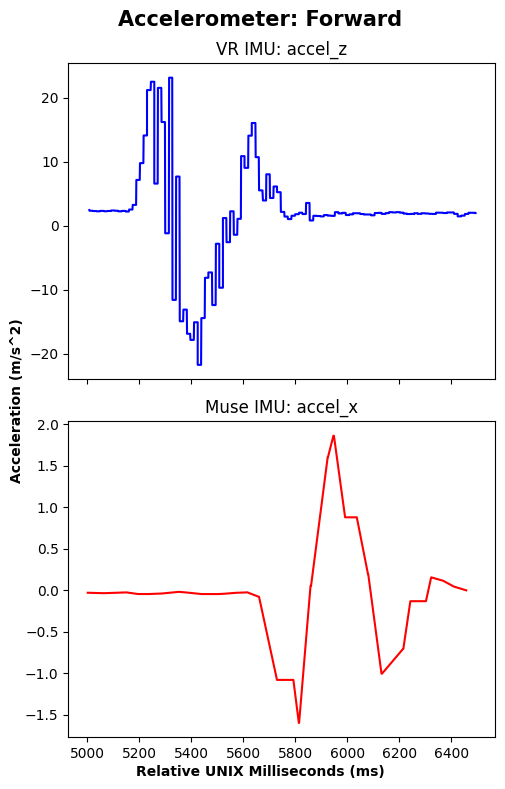

In [162]:
experiment.plot_individual('accel_z', 'accel_x', (5000,6500), 'Accelerometer: Forward', figsize=(5,7.5), outname='accel_forward.png')

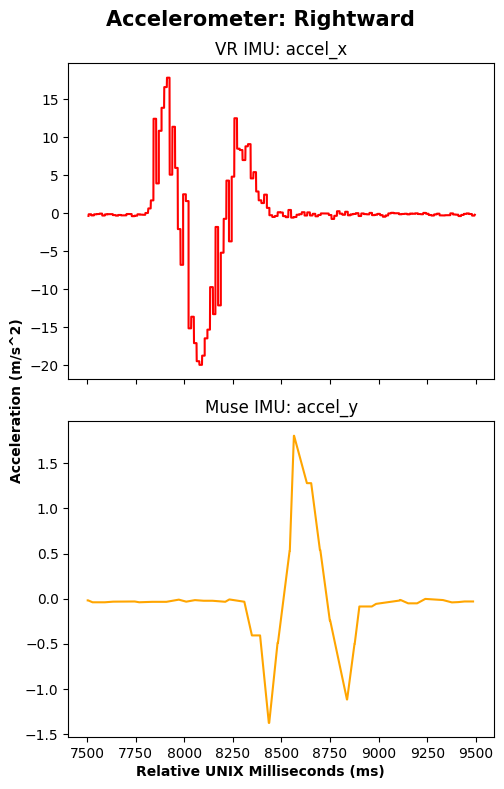

In [167]:
experiment.plot_individual('accel_x', 'accel_y', (7500,9500), 'Accelerometer: Rightward', figsize=(5,7.5), outname='accel_rightward.png')

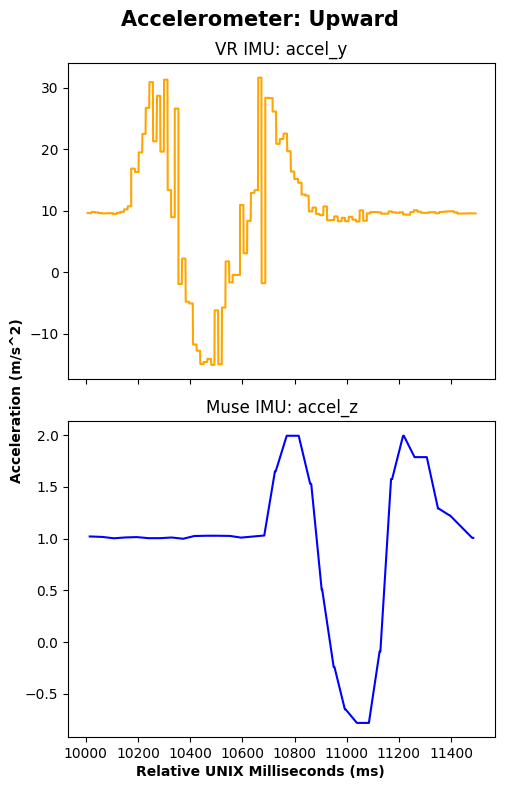

In [169]:
experiment.plot_individual('accel_y', 'accel_z', (10000,11500), 'Accelerometer: Upward', figsize=(5,7.5), outname='accel_upward.png')

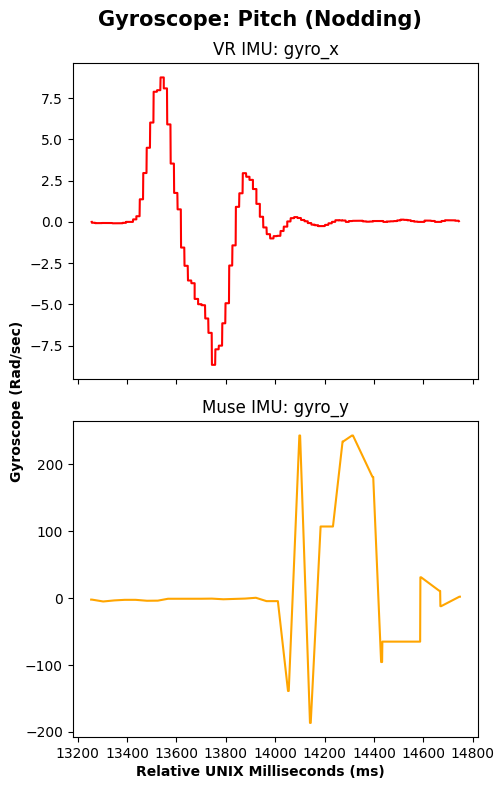

In [178]:
experiment.plot_individual('gyro_x', 'gyro_y', (13250,14750), 'Gyroscope: Pitch (Nodding)', figsize=(5,7.5), outname='gyro_pitch.png')

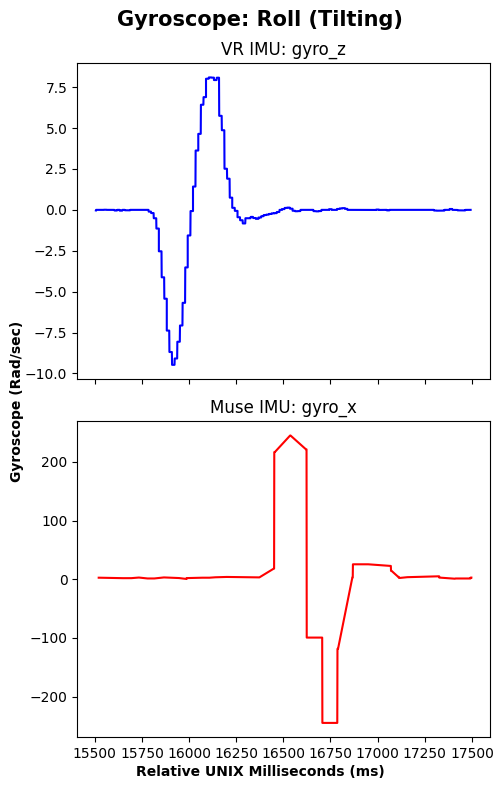

In [179]:
experiment.plot_individual('gyro_z', 'gyro_x', (15500,17500), 'Gyroscope: Roll (Tilting)', figsize=(5,7.5), outname='gyro_roll.png')

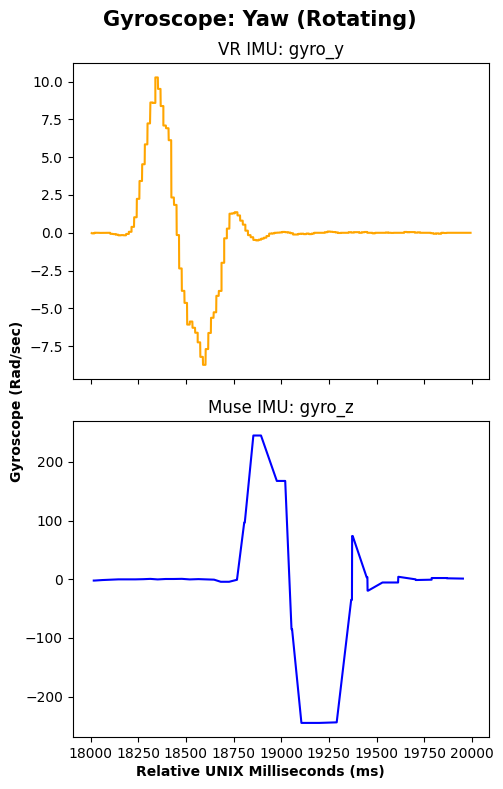

In [180]:
experiment.plot_individual('gyro_y', 'gyro_z', (18000,20000), 'Gyroscope: Yaw (Rotating)', figsize=(5,7.5), outname='gyro_yaw.png')

In summary, the following relationship table can be inferred:

|IMU Component|Meta Quest Pro (Unity)|Muse 2|
|:-|:-|:-|
|Accelerometer|`x+` (Rightward|`y-`|
|Accelerometer|`y+` (Upward)|`z+`|
|Accelerometer|`z+` (Forward)|`x-`|
|Gyroscope|`x+` (Pitch / Nod)|`y-`|
|Gyroscope|`y+` (Yaw / Looking Rightward)|`z+`|
|Gyroscope|`z-` (Roll / Right Tilt)|`x+`|

Both the Muse 2 and Unity use **left-handed** coordinate systems. However, the Muse 2's coordinate system is offset from Unity's by -90 degrees around the X-axis and 90 degrees around the Z-axis, relative to Unity Space.